# Fecha de entrega: 27/08/2022 (corresponde a clase 20)

# Algoritmo de clasificación: K-Nearest Neighbors

# Diccionario

**BTC_US_fv** 

- Date: fecha en YYYY-MM-DD (datetime64 [ns])
- Price: precio de cierre de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- Open: precio de apertura de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- High: precio más alto de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- Low: precio más bajo de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- Vol.: volumen de BTC (Número de intercambios) en el día de la fecha (float) (Variable numérica continua)
- Percentage_diff: diferencia porcentual del precio de BTC en la fecha [x+1] con respecto a la fecha [x] (float) (Variable numérica continua) 
- Target: 1 indica que en el día de la fecha el precio de BTC subió, y 0 que el precio bajó (float) (Se la tratará como variable categórica)
- Percentage_diff_USD_JPY: diferencia porcentual de la relación Dolar norteamericano y Yen japonés (float) (Variable numérica continua)
- Price_SP500: indica el valor de cierre de la bolsa de valores S%P500 (USD) (Variable numérica continua)
- Price_NASDAQ: indica el valor de cierre de la bolsa de valores NASDAQ (USD) (float) (Variable numérica continua)
- Price_DJ: indica el valor de cierre de la bolsa de valores Dow Jones (USD) (float) (Variable numérica continua)
- Price_US_Bond: indica el valor del bono a 10 años de EEUU (es uno de los bonos más relevantes a nivel macro) (float) (Variable numérica continua)
- I_Percentage_diff_ACPI: indica la diferencia porcentual interanual entre los valores del Consumer Price Index (float) (inflación) (Variable numérica continua)
- M_Percentage_diff_MCPI: indica la diferencia porcentual mensual entre los valores del Consumer Price Index (inflación) (float) (Variable numérica continua)
- FEDfunds: indica la tara de inflación de EEUU (float) (Variable numérica continua)
- Trend: tendencia de la variable [Price] a lo largo de la serie de tiempo (float) (Variable numérica continua)
- Seasonality: estacionariedad de la variable [Price] a lo largo de la serie de tiempo (float) (Variable numérica continua)
- Residuals: residualidad de la variable [Price] a lo largo de la serie de tiempo (float) (Variable numérica continua)
- BTC_cycle: ciclicidad de la variable [Price] a lo largo de la serie de tiempo (float) (Variable numérica continua)

# Librerías

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas_profiling
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.cm import ScalarMappable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

C:\Users\lucia\anaconda3\envs\acjup\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\lucia\anaconda3\envs\acjup\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Data acquisition

In [2]:
def gdriveColabPath(sharing_url):
  file_id=sharing_url.split('/')[-2]
  dwn_url='https://drive.google.com/uc?id=' + file_id
  return dwn_url

## Adquiriendo BTC_US_fv

In [3]:
# Se carga la base de datos de BTC_US_fv desde la carpeta compartida en el Google Drive
sharing_url = "https://drive.google.com/file/d/1khOq6X7TVPah5Gh-HHCyEt382MLPINvS/view?usp=sharing"

In [4]:
dwn_url=gdriveColabPath(sharing_url)
BTC_US_fv_df = pd.read_csv(dwn_url, sep=";", decimal=".")
BTC_US_fv_df.head()

,Date,Price,Open,High,Low,Vol.,Percentage_diff,Target,Price_SP500,Price_NASDAQ,Price_DJ,Price_US_Bond,I_Percentage_diff_ACPI,M_Percentage_diff_MCPI,FEDfunds,Percentage_diff_USD_JPY,Trend,Seasonality,Residuals,BTC_cycle
0,2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0,0,1064.88,2179.05,10097.90,2.954,1.34078,0.18693,0.18,-0.98,NaN,-3.979105,NaN,-1.869639e-06
1,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0,0,1071.25,2198.23,10154.43,2.954,1.34078,0.18693,0.18,0.21,NaN,8.917886,NaN,-1.538597e-06
2,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0,0,1083.48,2222.49,10229.96,2.954,1.34078,0.18693,0.18,0.75,NaN,1.150686,NaN,-1.206386e-06
3,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0,0,1069.59,2187.33,10120.53,2.954,1.34078,0.18693,0.18,-0.64,0.1,19.575231,-19.575231,-8.708768e-07
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0,0,1093.67,2245.89,10322.30,2.954,1.34078,0.18693,0.18,0.43,0.1,-15.128694,15.128694,-5.291847e-07


# Data wrangling

## Análisis pre-modelado

In [5]:
# Registros y columnas
BTC_US_fv_df.shape

(4386, 20)

In [6]:
# Nombre de columnas
BTC_US_fv_df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Percentage_diff',
       'Target', 'Price_SP500', 'Price_NASDAQ', 'Price_DJ', 'Price_US_Bond',
       'I_Percentage_diff_ACPI', 'M_Percentage_diff_MCPI', 'FEDfunds',
       'Percentage_diff_USD_JPY', 'Trend', 'Seasonality', 'Residuals',
       'BTC_cycle'],
      dtype='object')

In [7]:
# Tipos de datos de las variables
BTC_US_fv_df.dtypes

Date                        object
Price                      float64
Open                       float64
High                       float64
Low                        float64
Vol.                       float64
Percentage_diff            float64
Target                       int64
Price_SP500                float64
Price_NASDAQ               float64
Price_DJ                   float64
Price_US_Bond              float64
I_Percentage_diff_ACPI     float64
M_Percentage_diff_MCPI     float64
FEDfunds                   float64
Percentage_diff_USD_JPY    float64
Trend                      float64
Seasonality                float64
Residuals                  float64
BTC_cycle                  float64
dtype: object

In [8]:
# Columnas y cantidad de registros
BTC_US_fv_df.count()

Date                       4386
Price                      4386
Open                       4386
High                       4386
Low                        4386
Vol.                       4386
Percentage_diff            4386
Target                     4386
Price_SP500                4386
Price_NASDAQ               4386
Price_DJ                   4386
Price_US_Bond              4386
I_Percentage_diff_ACPI     4386
M_Percentage_diff_MCPI     4386
FEDfunds                   4386
Percentage_diff_USD_JPY    4386
Trend                      4380
Seasonality                4386
Residuals                  4380
BTC_cycle                  4386
dtype: int64

In [9]:
# Valores NaN
BTC_US_fv_df.isnull().sum()

Date                       0
Price                      0
Open                       0
High                       0
Low                        0
Vol.                       0
Percentage_diff            0
Target                     0
Price_SP500                0
Price_NASDAQ               0
Price_DJ                   0
Price_US_Bond              0
I_Percentage_diff_ACPI     0
M_Percentage_diff_MCPI     0
FEDfunds                   0
Percentage_diff_USD_JPY    0
Trend                      6
Seasonality                0
Residuals                  6
BTC_cycle                  0
dtype: int64

In [10]:
BTC_US_fv_df.head()

,Date,Price,Open,High,Low,Vol.,Percentage_diff,Target,Price_SP500,Price_NASDAQ,Price_DJ,Price_US_Bond,I_Percentage_diff_ACPI,M_Percentage_diff_MCPI,FEDfunds,Percentage_diff_USD_JPY,Trend,Seasonality,Residuals,BTC_cycle
0,2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0,0,1064.88,2179.05,10097.90,2.954,1.34078,0.18693,0.18,-0.98,NaN,-3.979105,NaN,-1.869639e-06
1,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0,0,1071.25,2198.23,10154.43,2.954,1.34078,0.18693,0.18,0.21,NaN,8.917886,NaN,-1.538597e-06
2,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0,0,1083.48,2222.49,10229.96,2.954,1.34078,0.18693,0.18,0.75,NaN,1.150686,NaN,-1.206386e-06
3,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0,0,1069.59,2187.33,10120.53,2.954,1.34078,0.18693,0.18,-0.64,0.1,19.575231,-19.575231,-8.708768e-07
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0,0,1093.67,2245.89,10322.30,2.954,1.34078,0.18693,0.18,0.43,0.1,-15.128694,15.128694,-5.291847e-07


Observaciones:

Se observaron varios registros NaN en "BTC_US_fv.csv". 

Esto implica la necesidad de tomar una decisión con respecto a este tipo de valores (instancia previa al modelado). 

Se descarta rellenar los NaN con promedios de valores previos y/o posteriores por varias razones:

1. En las variables [Trend] y [Residuals], 3 de los 6 valores NaN se encuentran al principio de la serie, y los restantes 3 al final de la misma. Esto significa que no se puede hacer un promedio con valores anteriores y posteriores a los valores NaN sino solo con anteriores o posteriores según el caso. Proceder con un promedio con los datos anteriores o posteriores en una serie de tiempo supone un problema extra (¿cuántos valores hacia atrás o hacia adelante se deben tomar?, ¿cuál es el grado de autocorrelación con los valores anteriores o posteriores?, entre otros). 


2. En la variable [Residuals] hay valores positivos y negativos en los registros anteriores y posteriores inmediatos según el caso. Esto también añade un problema extra (¿qué signo se debería utilizar si se rellenan esos casilleros?).


3. Al no tratarse de un problema de regresión lineal del valor que tomaría el precio de BTC en el registro siguiente sino un problema de clasificación, la eliminación de los valores NaN no afectaría en demasía la predicción del modelo a pesar de la autocorrelación referida en el punto 2. Si se considera eliminar los 12 registros NaN (6 en [Residual] y 6 en [Trend] ) se estaría solamente eliminando un (6*100/4386 =) 0.136 % de los datos. 

Se eliminarán los valores NaN dado que los modelos no los toleran y no impactan en el marco general del proyecto (ver razones aducidas arriba).

## Ultimas manipulaciones pre-modelado

Se reindexa el data set que se modelará a fin de que la variable [Date] funcione como nuevo índice de la base de datos.

In [11]:
# Se crea una copia de BTC_US_fv_df con nombre BTC_US y se la reindexa con la variable [Date] como nuevo índice
BTC_US = BTC_US_fv_df.set_index("Date")

In [12]:
BTC_US.tail()

,Price,Open,High,Low,Vol.,Percentage_diff,Target,Price_SP500,Price_NASDAQ,Price_DJ,Price_US_Bond,I_Percentage_diff_ACPI,M_Percentage_diff_MCPI,FEDfunds,Percentage_diff_USD_JPY,Trend,Seasonality,Residuals,BTC_cycle
Date,,,,,,,,,,,,,,,,,,,
2022-07-16,21209.9,20825.2,21561.3,20484.4,136890.0,1.85,1,3863.16,11452.42,31286.02,2.889,8.48213,-0.0193,1.68,-0.27,21370.371429,-0.183737,-160.287691,-154.061979
2022-07-17,20785.6,21209.8,21654.4,20755.2,132810.0,-2.00,0,3863.16,11452.42,31286.02,2.889,8.48213,-0.0193,1.68,-0.27,21784.528571,-3.979105,-994.949467,-745.841392
2022-07-18,22525.8,20785.6,22714.9,20770.6,279720.0,8.37,1,3830.85,11360.05,31071.75,2.889,8.48213,-0.0193,1.68,-0.30,NaN,8.917886,NaN,822.393782
2022-07-19,23410.2,22529.3,23757.3,21581.8,308910.0,3.93,1,3936.69,11713.15,31824.71,2.889,8.48213,-0.0193,1.68,0.04,NaN,1.150686,NaN,1532.500614
2022-07-20,23149.1,23412.0,23429.9,22965.9,290210.0,-1.12,0,3936.69,11713.15,31824.71,2.889,8.48213,-0.0193,1.68,-0.08,NaN,19.575231,NaN,1096.422183


Dado que en la práctica real solo se tiene hasta los valores del registro anterior al que se quiere predecir se intenta hacer un shift (-1) a la variable [Target]. Se entiende que así (en caso de que el modelo prediga con previsibilidad suficiente) se podría estar seguro de que después vendría el valor de [Target] original sin shift (-1).

In [13]:
# Se genera un back up
BTC_US_2 = BTC_US.copy()

In [14]:
# Se realiza el shift 
BTC_US_2 ["Target"] = BTC_US ["Target"].shift(-1)

In [15]:
BTC_US_2.tail()

,Price,Open,High,Low,Vol.,Percentage_diff,Target,Price_SP500,Price_NASDAQ,Price_DJ,Price_US_Bond,I_Percentage_diff_ACPI,M_Percentage_diff_MCPI,FEDfunds,Percentage_diff_USD_JPY,Trend,Seasonality,Residuals,BTC_cycle
Date,,,,,,,,,,,,,,,,,,,
2022-07-16,21209.9,20825.2,21561.3,20484.4,136890.0,1.85,0.0,3863.16,11452.42,31286.02,2.889,8.48213,-0.0193,1.68,-0.27,21370.371429,-0.183737,-160.287691,-154.061979
2022-07-17,20785.6,21209.8,21654.4,20755.2,132810.0,-2.00,1.0,3863.16,11452.42,31286.02,2.889,8.48213,-0.0193,1.68,-0.27,21784.528571,-3.979105,-994.949467,-745.841392
2022-07-18,22525.8,20785.6,22714.9,20770.6,279720.0,8.37,1.0,3830.85,11360.05,31071.75,2.889,8.48213,-0.0193,1.68,-0.30,NaN,8.917886,NaN,822.393782
2022-07-19,23410.2,22529.3,23757.3,21581.8,308910.0,3.93,0.0,3936.69,11713.15,31824.71,2.889,8.48213,-0.0193,1.68,0.04,NaN,1.150686,NaN,1532.500614
2022-07-20,23149.1,23412.0,23429.9,22965.9,290210.0,-1.12,NaN,3936.69,11713.15,31824.71,2.889,8.48213,-0.0193,1.68,-0.08,NaN,19.575231,NaN,1096.422183


Se elimina el registro NaN de la variable [Target] dado que los modelos no pueden procesar este tipo de datos

In [16]:
BTC_US_2 = BTC_US_2 [0:4385]

In [17]:
BTC_US_2.isnull().sum()

Price                      0
Open                       0
High                       0
Low                        0
Vol.                       0
Percentage_diff            0
Target                     0
Price_SP500                0
Price_NASDAQ               0
Price_DJ                   0
Price_US_Bond              0
I_Percentage_diff_ACPI     0
M_Percentage_diff_MCPI     0
FEDfunds                   0
Percentage_diff_USD_JPY    0
Trend                      5
Seasonality                0
Residuals                  5
BTC_cycle                  0
dtype: int64

Se eliminan los valores NaN del resto de las columnas ([Trend] y [Seasonality])

In [18]:
BTC_US_2 = BTC_US_2.dropna()

In [19]:
BTC_US_2.isnull().sum()

Price                      0
Open                       0
High                       0
Low                        0
Vol.                       0
Percentage_diff            0
Target                     0
Price_SP500                0
Price_NASDAQ               0
Price_DJ                   0
Price_US_Bond              0
I_Percentage_diff_ACPI     0
M_Percentage_diff_MCPI     0
FEDfunds                   0
Percentage_diff_USD_JPY    0
Trend                      0
Seasonality                0
Residuals                  0
BTC_cycle                  0
dtype: int64

In [20]:
BTC_US_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380 entries, 2010-07-21 to 2022-07-17
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Price                    4380 non-null   float64
 1   Open                     4380 non-null   float64
 2   High                     4380 non-null   float64
 3   Low                      4380 non-null   float64
 4   Vol.                     4380 non-null   float64
 5   Percentage_diff          4380 non-null   float64
 6   Target                   4380 non-null   float64
 7   Price_SP500              4380 non-null   float64
 8   Price_NASDAQ             4380 non-null   float64
 9   Price_DJ                 4380 non-null   float64
 10  Price_US_Bond            4380 non-null   float64
 11  I_Percentage_diff_ACPI   4380 non-null   float64
 12  M_Percentage_diff_MCPI   4380 non-null   float64
 13  FEDfunds                 4380 non-null   float64
 14  Percentage_dif

# Modelado (KNN)

**...Recordando que...**

*Objetivo general del proyecto*

I.	Diseñar diversos modelos de machine learning capaces de predecir con cierto grado de previsibilidad positiva (>50/55%) el dinamismo del precio de Bitcoin en el corto plazo, es decir, si el precio de este criptoactivo subirá o bajará en la temporalidad estudiada (1 día).

**...Recordando que...**

*Objetivo específico del proyecto*

III.	Diseñar diversos modelos de machine learning capaces de predecir con cierto grado de previsibilidad positiva (>50/55%) y a corto plazo, el movimiento alcista o bajista del precio de BTC.

**Explicación**:

En lo que sigue se procederá a realizar varios modelos supervisados de clasificación de tipo "KNN". 

Estos serán configurados con diversos hiperparámetros a fin de encontrar el resultado más óptimo para este data set.

La variable target del modelo es la columna [Target] de BTC_US_2.

## Modelo 1

In [21]:
# Se generan las variables X e y (target)
X = BTC_US_2.drop (["Target"], axis=1)
y = BTC_US_2 ["Target"].values.reshape(-1,1)

In [22]:
# Se escalan los datos

escalador = MinMaxScaler()

X = escalador.fit_transform(X)

y= escalador.fit_transform(y)

In [23]:
# Se separa la data en train y test
# Se decide aplicar stratify
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                        stratify=y,
                                        test_size=0.3,
                                        random_state=11)

In [24]:
# Se entrena el modelo (k=3)
clasificador = KNeighborsClassifier (n_neighbors=3)

clasificador.fit(X_train, y_train);

In [25]:
y_train_pred = clasificador.predict(X_train) 
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy)

y_test_pred = clasificador.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación es:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.7749510763209393
% de aciertos sobre el set de evaluación es: 0.58675799086758


Observaciones:
- El modelo tiene un 58,6% de capacidad de predicción de los próximos registros.

## Hyperparameter tuning

In [26]:
# Se instancia el modelo
KNN = KNeighborsClassifier() 

In [27]:
# Se definen los parámetros de búsqueda
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_neighbors': np.arange(1, 100),
    'weights': ['uniform', 'distance', 'callable'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': np.arange(1, 100)
     }

grid_knn = RandomizedSearchCV(KNN, param_grid, scoring='accuracy', n_iter=100, cv=5, verbose=2)

In [28]:
# Se entrena el modelo
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END algorithm=ball_tree, leaf_size=91, n_neighbors=43, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=91, n_neighbors=43, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=91, n_neighbors=43, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=91, n_neighbors=43, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=91, n_neighbors=43, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=47, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=47, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=47, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=47, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=8, n_neighbors=47, weights=distance; total time=   0.

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=100,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69,...
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'weights': ['uniform', 'distance',
                                                    'callable']},
                   scoring='accuracy', verbose=2)

In [29]:
# Se obtiene el mejor modelo
print(grid_knn.best_params_)

{'weights': 'distance', 'n_neighbors': 73, 'leaf_size': 48, 'algorithm': 'brute'}


In [30]:
print(grid_knn.best_estimator_)

KNeighborsClassifier(algorithm='brute', leaf_size=48, n_neighbors=73,
                     weights='distance')


Observación:
- Se entiende que el mejor modelo tiene un k=73

In [31]:
y_train_pred = grid_knn.predict(X_train) 
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy)

% de aciertos sobre el set de entrenamiento: 1.0


In [32]:
y_test_pred = grid_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación es:',test_accuracy)

% de aciertos sobre el set de evaluación es: 0.6080669710806698


Observaciones:
- La modificación de los hiperparámetros no mejoró el modelo. No se pudo resolver el overfitting.

[[397 281]
 [234 402]]


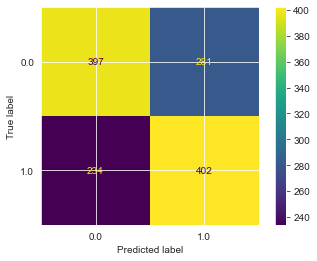

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Predicciones
predictions = grid_knn.predict(X_test)

#Matriz de Confusión
print(confusion_matrix(y_test, predictions))

#Ploteamos la Matriz
plot_confusion_matrix(grid_knn, X_test, y_test)
plt.show()

Observaciones:
- El modelo resulta en muchos falsos positivos y negativos. Al modelo le cuesta reconocer las clases.

Accuracy of the classifier is: 0.6080669710806698
Precision Score of the classifier is: 0.5885797950219619
Recall Score of the classifier is: 0.6320754716981132
F1 Score of the classifier is: 0.6095526914329036
AUC for our classifier is: 0.6482834270236173


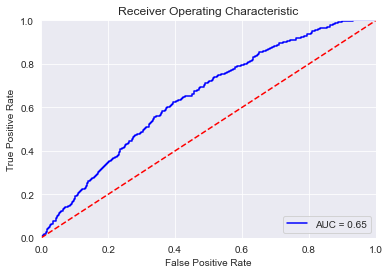

In [34]:
# Accuracy
print(f"Accuracy of the classifier is: {accuracy_score(y_test, predictions)}")

# Precision
from sklearn.metrics import precision_score
print(f"Precision Score of the classifier is: {precision_score(y_test, predictions)}")

# Recall
from sklearn.metrics import recall_score
print(f"Recall Score of the classifier is: {recall_score(y_test, predictions)}")

# Calculo del F1 score
from sklearn.metrics import f1_score
print(f"F1 Score of the classifier is: {f1_score(y_test, predictions)}")

#Template CURVA - ROC

from sklearn.metrics import roc_curve, auc

class_probabilities = grid_knn.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Observaciones:
- El mejor modelo obtenido predice la subida y bajada de BTC en un 58,6% approx.